# <center>Churn Analysis & Modeling

## Setting up environment

Loading required libraries and setting any up any required variables.

In [1]:
import re
import math

# Warning Libraries 
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.display import Markdown, display

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt     
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
sns.set_style("whitegrid")

# COLORS = ['#f28e2b', '#4e79a7','#59a14f', '#edc948','#b07aa1','#ff9da7','#9c755f','#bab0ac']

## Outline

1. [Dataset](#dataset)
2. [Data Exploration](#data_exploration)
3. [Data Normalization](#data_normalization)
4. [Model](#model)

## Dataset

Dataset originally from [Kaggle: Customer Churn Prediction](https://www.kaggle.com/datasets/rashadrmammadov*/customer-churn-dataset).

### Column Descriptions

- **customerID**: Unique identifier for each customer.
- **gender**: Gender of the customer *(Male, Female)*.
- **SeniorCitizen**: Whether the customer is a senior citizen or not *(1=Yes, 0=No)*.
- **Partner**: Whether the customer has a partner or not *(Yes, No)*.
- **Dependents**: Whether the customer has dependents or not *(Yes, No)*.
- **tenure**: Number of months the customer has stayed with the company.
- **PhoneService**: Whether the customer has a phone service or not *(Yes, No)*.
- **MultipleLines**: Whether the customer has multiple lines or not *(Yes, No, No phone service)*.
- **InternetService**: Type of internet service the customer has *(DSL, Fiber optic, No)*.
- **OnlineSecurity**: Whether the customer has online security or not *(Yes, No, No internet service)*.
- **OnlineBackup**: Whether the customer has online backup or not *(Yes, No, No internet service)*.
- **DeviceProtection**: Whether the customer has device protection or not *(Yes, No, No internet service)*.
- **TechSupport**: Whether the customer has tech support or not *(Yes, No, No internet service)*.
- **StreamingTV**: Whether the customer has streaming TV or not *(Yes, No, No internet service)*.
- **StreamingMovies**: Whether the customer has streaming movies or not *(Yes, No, No internet service)*.
- **Contract**: The contract term of the customer *(Month-to-month, One year, Two year)*.
- **PaperlessBilling**: Whether the customer has paperless billing or not *(Yes, No)*.
- **PaymentMethod**: The payment method of the customer *(Electronic check, Mailed check, Bank transfer, Credit* card).
- **MonthlyCharges**: The amount charged to the customer monthly.
- **TotalCharges**: The total amount charged to the customer.
- **Churn**: Whether the customer churned or not *(Yes, No)*.


In [2]:
df = pd.read_csv('../data/customer_churn_data.csv')
df_raw = df.copy()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST0000,Male,0,No,Yes,23,No,No phone service,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,No
1,CUST0001,Female,0,Yes,No,43,No,No phone service,DSL,Yes,...,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,Yes
2,CUST0002,Male,1,No,No,51,Yes,No,DSL,No,...,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,Yes
3,CUST0003,Male,1,No,No,72,Yes,Yes,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,No
4,CUST0004,Male,1,No,No,25,Yes,Yes,DSL,No,...,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,Yes


In [3]:
Markdown(f"Dataset Dimension: **{df.shape[0]}** rows,  **{df.shape[1]}** columns")

Dataset Dimension: **5880** rows,  **21** columns

### Removing unneeded columns


In [4]:
df = df.drop(columns=['customerID'])

### Convert object colums to categories

Given all Converting the **string** columns to **categories** will help further analysis.


In [5]:
columns_to_convert = df.select_dtypes(include=['object']).columns.tolist()
df[columns_to_convert] = df[columns_to_convert].apply(lambda x: x.astype('category'))
# df.info()

### Summary of Categorical and Quantitative Features

In [6]:
df.describe(include='category').T

,count,unique,top,freq
gender,5880,2,Male,2950
Partner,5880,2,Yes,2995
Dependents,5880,2,No,3004
PhoneService,5880,2,Yes,2941
MultipleLines,5880,3,No phone service,2939
InternetService,5880,3,No,2029
OnlineSecurity,5880,3,No internet service,2029
OnlineBackup,5880,3,No internet service,2029
DeviceProtection,5880,3,No internet service,2029
TechSupport,5880,3,No internet service,2029


In [7]:
df.describe().T.style.set_precision(1)

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5880.0,0.5,0.5,0.0,0.0,1.0,1.0,1.0
tenure,5880.0,36.5,20.9,1.0,18.0,37.0,55.0,72.0
MonthlyCharges,5880.0,70.2,28.8,20.0,45.7,70.2,95.5,120.0
TotalCharges,5880.0,2566.8,1910.0,20.0,1020.2,2136.4,3767.7,8589.6


### Null Values

In [8]:
# pd.DataFrame(df.isnull().sum())
# sns.heatmap(df.isnull(),cmap = 'magma',cbar = False);
if df.isnull().sum().sum() == 0:
    display(Markdown("**No missing values found.**"))

**No missing values found.**

### Summary of Values

In [9]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

def process_column(df, col):
    value_counts = df[col].value_counts()
    total = len(df)
    percentages = value_counts / total * 100

    # Create formatted strings
    # formatted = value_counts.index.map(lambda x: f"{x}\n({value_counts[x]}, {percentages[x]:.1f}%)")
    formatted = value_counts.index.map(lambda x: f"{x} ({percentages[x]:.1f}%)")
    
    return pd.Series(formatted, name=col)

unique_categories = [process_column(df, col) for col in categorical_columns]
sorted_unique_categories = sorted(unique_categories, key=lambda x: (len(x)))

# Simple version of the table
# unique_categories = [pd.Series(df[col].unique(), name=col) for col in categorical_columns]
# sorted_unique_categories = sorted(unique_categories, key=lambda x: (len(x)))

def custom_sort(series, priority_list=['Fiber optic', 'Yes', 'No']):
    # Convert to categorical type with custom ordering
    cat_type = pd.CategoricalDtype(categories=priority_list + [x for x in series.unique() if x not in priority_list], ordered=True)
    return series.astype(cat_type).sort_values().reset_index(drop=True)

unique_df = pd.concat(sorted_unique_categories, axis=1)
unique_df = unique_df.apply(lambda x: x.astype('str').replace("nan", ""))
unique_df = unique_df.apply(custom_sort)

unique_df.T.style.hide(axis='columns').set_caption("<h3>Summary of Categorical Values")


gender,Male (50.2%),Female (49.8%),,
Partner,Yes (50.9%),No (49.1%),,
Dependents,No (51.1%),Yes (48.9%),,
PhoneService,Yes (50.0%),No (50.0%),,
PaperlessBilling,No (50.9%),Yes (49.1%),,
Churn,No (50.7%),Yes (49.3%),,
MultipleLines,No phone service (50.0%),Yes (25.7%),No (24.3%),
InternetService,No (34.5%),DSL (32.9%),Fiber optic (32.6%),
OnlineSecurity,No internet service (34.5%),No (33.1%),Yes (32.4%),
OnlineBackup,No internet service (34.5%),No (33.8%),Yes (31.7%),
DeviceProtection,No internet service (34.5%),Yes (32.8%),No (32.7%),


## Data exploration

In [10]:
def countplot(columns):
    ncols=3
    nrows=math.ceil(len(columns) / ncols)
    fig_size = (ncols * 7, nrows * 3)

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=fig_size)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        sns.countplot(x=col, data=df, hue='Churn', ax=ax)
        ax.set_title(f'{col}')
        ax.legend_.remove()  # Remove the legend for each subplot
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(left=False, bottom=False)

        # Calculate total counts for percentages
        total_counts = df[col].value_counts().sum()

        # Add values on top of each bar
        for p in ax.patches:
            height = p.get_height()
            if height > 0:  
                percentage = 100 * height / total_counts
                # ax.annotate(format(p.get_height(), '.0f'),
                ax.annotate(f'{percentage:.0f}%',
                            # (p.get_x() + p.get_width() / 2., height / 2),  # center
                            (p.get_x() + p.get_width() / 2., p.get_height()),  # top
                            ha='center', va='center',
                            xytext=(0, 6),
                            textcoords='offset points')

        # Add headroom by increasing the y-axis limit
        ax.set_ylim(0, max([p.get_height() for p in ax.patches]) * 1.15)

    plt.show()

### Churn Distribution by Categorical Features


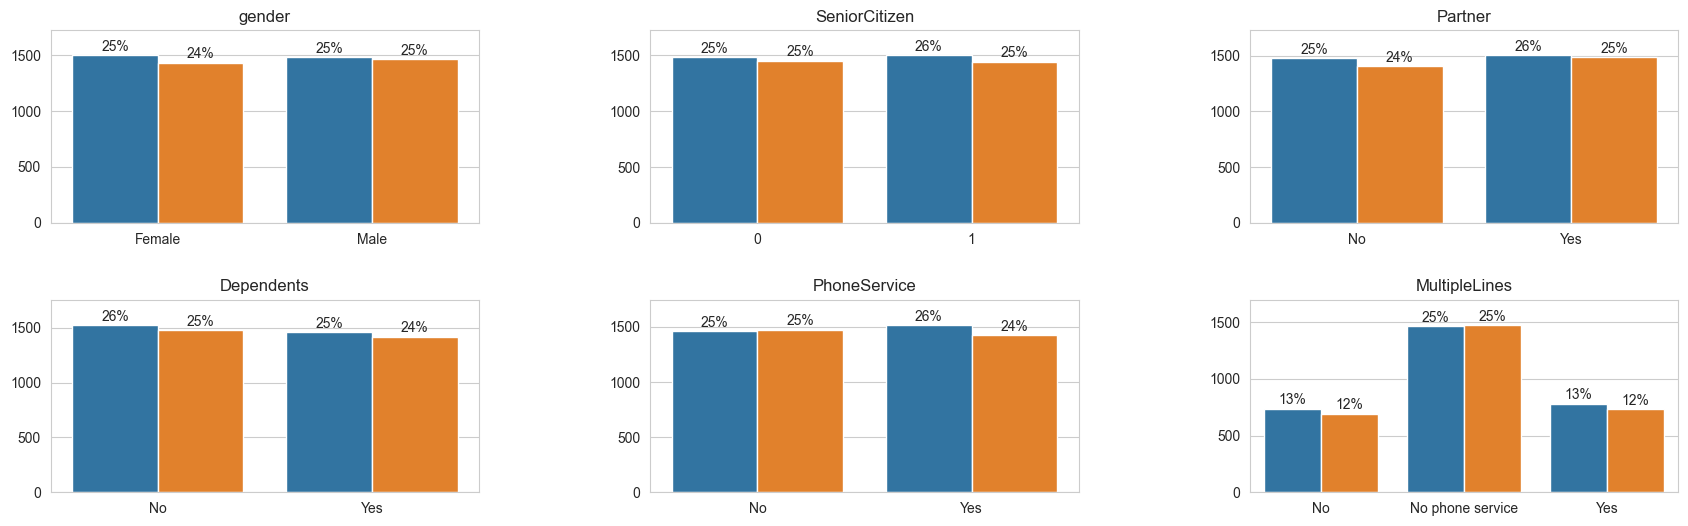

In [11]:
cols = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines"]
countplot(cols)

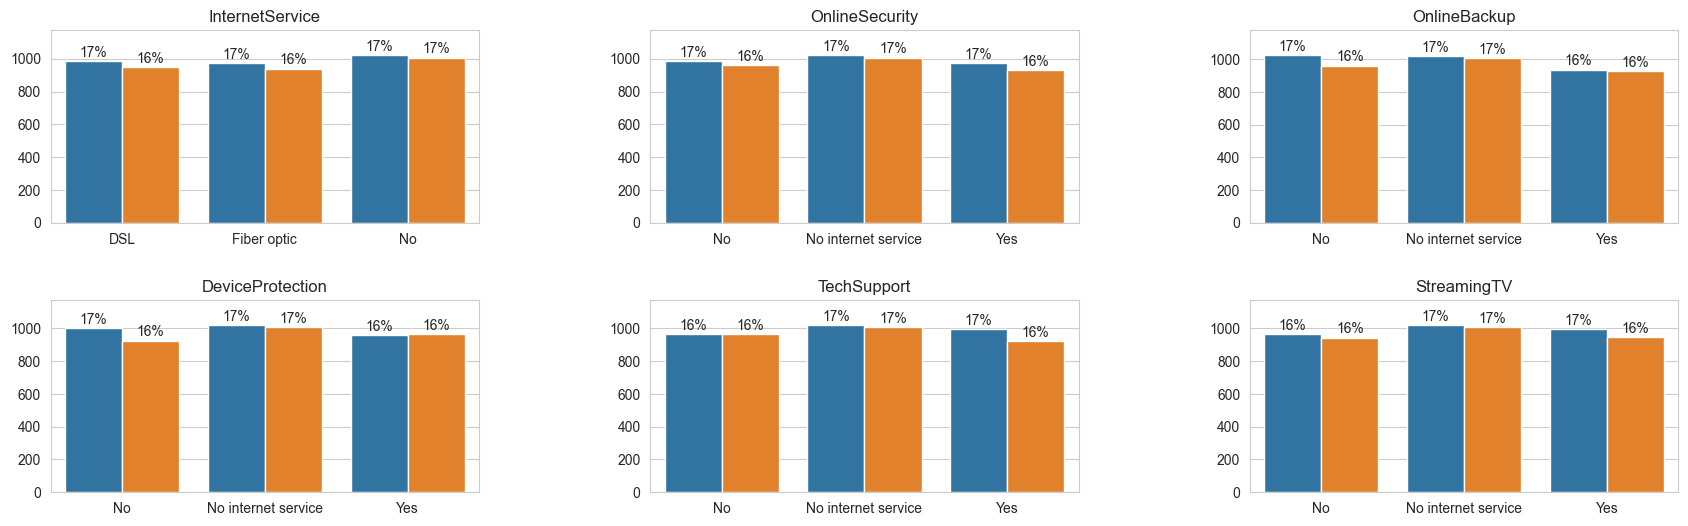

In [12]:
cols = ["InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV"]
countplot(cols)

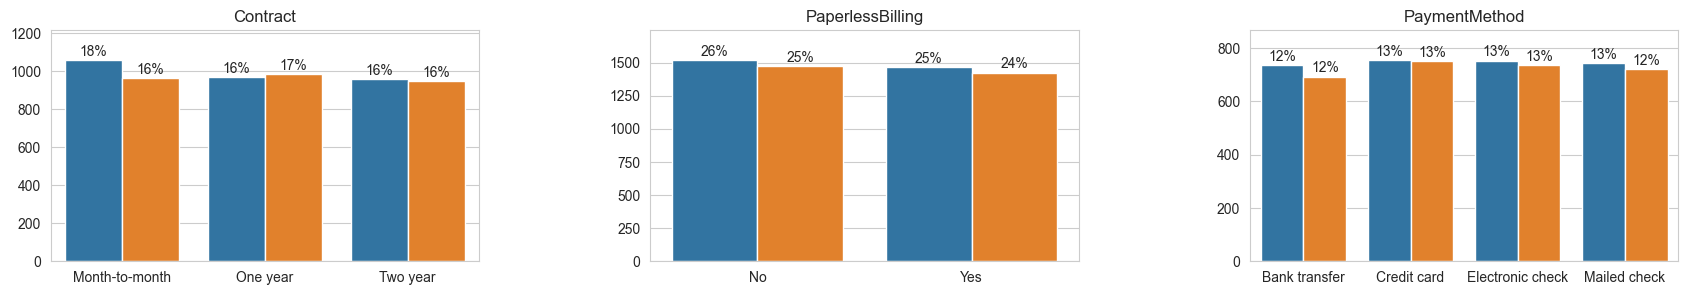

In [13]:
cols = ["Contract", "PaperlessBilling", "PaymentMethod"]
countplot(cols)

## Data Normalization

In [14]:
train = df_raw.copy()
train['Churn'] = train['Churn'].map({'No': 0, 'Yes': 1})
train.drop(columns=['customerID'], inplace=True)
train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,No,Yes,23,No,No phone service,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,0
1,Female,0,Yes,No,43,No,No phone service,DSL,Yes,No,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,1
2,Male,1,No,No,51,Yes,No,DSL,No,Yes,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,1
3,Male,1,No,No,72,Yes,Yes,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,0
4,Male,1,No,No,25,Yes,Yes,DSL,No,No,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,1


In [15]:
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

# 1. Data Preprocessing
# Convert categorical variables to numeric using one-hot encoding
df_encoded = pd.get_dummies(train, columns=categorical_columns, drop_first=True)

# Separate features and target variable
X = df_encoded.drop(['Churn'], axis=1)
y = df_encoded['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Markdown(f"**Training set**: {X_train.shape[0]} rows<br>**Testing set**: {X_test.shape[0]} rows")

**Training set**: 4704 rows<br>**Testing set**: 1176 rows

In [16]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pd.DataFrame(X_test_scaled, columns=X_train.columns).head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.992376,-0.806906,1.103999,-0.282181,-0.990690,0.973978,-0.977298,-0.991954,0.991954,-0.588807,...,1.370060,-0.689925,1.370060,-0.698331,-0.705754,1.443111,1.007683,-0.587170,-0.580623,-0.574732
1,0.992376,-0.232940,0.754619,0.187387,-0.990690,0.973978,1.023229,1.008111,-1.008111,1.698350,...,-0.729895,1.449433,-0.729895,-0.698331,-0.705754,1.443111,-0.992376,-0.587170,-0.580623,1.739942
2,0.992376,-0.615584,1.585436,0.104951,1.009398,0.973978,-0.977298,1.008111,-1.008111,1.698350,...,-0.729895,1.449433,-0.729895,1.431986,-0.705754,-0.692947,-0.992376,-0.587170,-0.580623,-0.574732
3,0.992376,-0.137279,0.374044,0.087952,-0.990690,0.973978,-0.977298,1.008111,-1.008111,1.698350,...,1.370060,-0.689925,1.370060,-0.698331,1.416924,-0.692947,1.007683,1.703085,-0.580623,-0.574732
4,-1.007683,1.441127,0.015653,1.117353,1.009398,-1.026717,-0.977298,1.008111,-1.008111,-0.588807,...,-0.729895,1.449433,-0.729895,1.431986,1.416924,-0.692947,-0.992376,-0.587170,1.722287,-0.574732


## Model

### Training the model

In [17]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

### Running the predictions

In [18]:
y_pred = model.predict(X_test_scaled)

### Evaluating the model

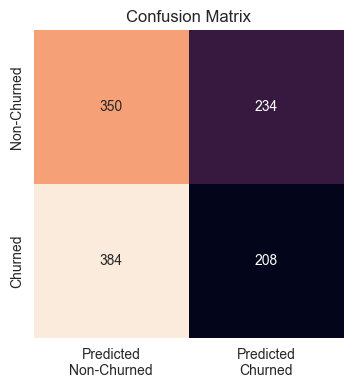

In [19]:
cm = confusion_matrix(y_test, y_pred)


# Create the heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['Predicted\nNon-Churned', 'Predicted\nChurned'],
            yticklabels=['Non-Churned', 'Churned'],
            cbar=False,
            annot_kws={"size": 10})

# Set title and labels
plt.title('Confusion Matrix')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

# pd.DataFrame(cm, columns=['Non-Churned', 'Churned'], index=['Non-Churned', 'Churned']).style.set_caption("<h3>Confusion Matrix")

In [20]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).style.set_precision(2).set_caption("<h3>Classification Report")

,0,1,accuracy,macro avg,weighted avg
precision,0.48,0.47,0.47,0.47,0.47
recall,0.60,0.35,0.47,0.48,0.47
f1-score,0.53,0.40,0.47,0.47,0.47
support,584.00,592.00,0.47,1176.00,1176.00


In [21]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': abs(model.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)
pd.DataFrame(feature_importance.head(15)).style.set_caption("<h3> Most important features").hide(axis=0).bar()

feature,importance
Contract_Two year,0.064093
Contract_One year,0.062801
TechSupport_Yes,0.061213
DeviceProtection_Yes,0.036151
PaymentMethod_Mailed check,0.031776
PaymentMethod_Electronic check,0.028671
OnlineBackup_Yes,0.027796
TotalCharges,0.022303
PhoneService_Yes,0.020321
MultipleLines_No phone service,0.020321


### Receiver Operating Characteristic (ROC) Curve

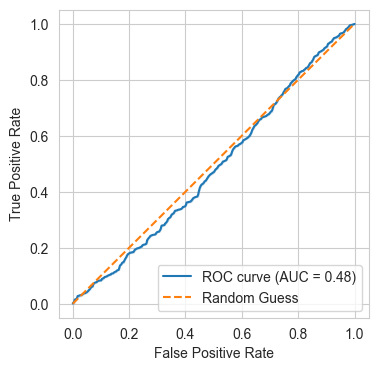

In [22]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(4, 4))
sns.lineplot(x=fpr, y=tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()